
Iteration 1/50
Train Loss: 0.5869 | Train Accuracy: 0.6881

Iteration 2/50
Train Loss: 0.4721 | Train Accuracy: 0.7647

Iteration 3/50
Train Loss: 0.4050 | Train Accuracy: 0.8307

Iteration 4/50
Train Loss: 0.3354 | Train Accuracy: 0.8734

Iteration 5/50
Train Loss: 0.2572 | Train Accuracy: 0.9020

Iteration 6/50
Train Loss: 0.2462 | Train Accuracy: 0.9002

Iteration 7/50
Train Loss: 0.2278 | Train Accuracy: 0.9073

Iteration 8/50
Train Loss: 0.2020 | Train Accuracy: 0.9180

Iteration 9/50
Train Loss: 0.1897 | Train Accuracy: 0.9216

Iteration 10/50
Train Loss: 0.1626 | Train Accuracy: 0.9394

Iteration 11/50
Train Loss: 0.1521 | Train Accuracy: 0.9394

Iteration 12/50
Train Loss: 0.1320 | Train Accuracy: 0.9537

Iteration 13/50
Train Loss: 0.1310 | Train Accuracy: 0.9483

Iteration 14/50
Train Loss: 0.1310 | Train Accuracy: 0.9483

Iteration 15/50
Train Loss: 0.1299 | Train Accuracy: 0.9430

Iteration 16/50
Train Loss: 0.1238 | Train Accuracy: 0.9483

Iteration 17/50
Train Loss: 0.12

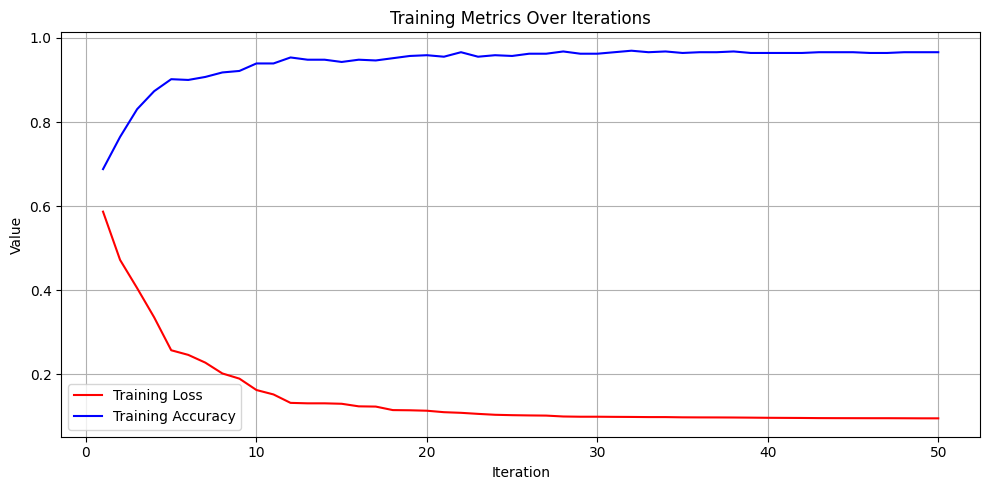

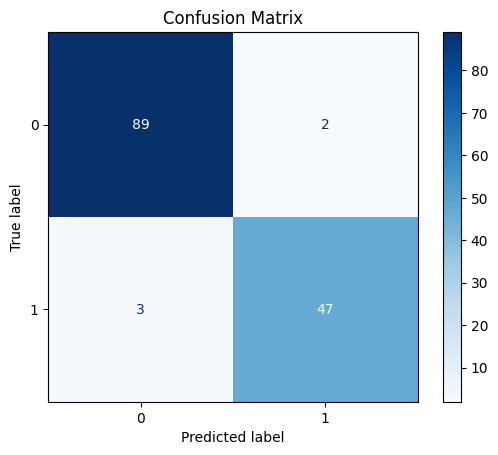

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load and preprocess dataset
df = pd.read_csv('autism_screening.csv')
df = df.dropna()
columns_to_drop = ['used_app_before', 'country_of_res', 'age_desc', 'relation', 'who_completed_the_test']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Encode categorical variables
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# Normalize
X = MinMaxScaler().fit_transform(df.drop('Class/ASD', axis=1))
y = df['Class/ASD'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_losses = []
train_accuracies = []

# PSO Parameters
n_particles = 50
n_iter = 50
w_max, w_min, c1, c2 = 0.9, 0.2, 2, 2

# Model architecture
def create_model():
    return Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(12, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

# Flatten/unflatten weights
def flatten_weights(weights):
    return np.concatenate([w.flatten() for w in weights])

def unflatten_weights(flattened, model):
    shapes = [w.shape for w in model.get_weights()]
    new_weights, idx = [], 0
    for shape in shapes:
        size = np.prod(shape)
        new_weights.append(flattened[idx:idx+size].reshape(shape))
        idx += size
    return new_weights

# Fitness function = loss on train set
def fitness(position, return_metrics=False):
    model = create_model()
    model.set_weights(unflatten_weights(position, model))
    y_pred_probs = model.predict(X_train, verbose=0).flatten()
    loss = tf.keras.losses.binary_crossentropy(y_train, y_pred_probs).numpy().mean()
    y_pred_classes = (y_pred_probs > 0.5).astype(int)
    acc = accuracy_score(y_train, y_pred_classes)
    if return_metrics:
        return loss, acc
    return loss

# Initialize particles
model_example = create_model()
dim = len(flatten_weights(model_example.get_weights()))
lb, ub = -1 * np.ones(dim), 1 * np.ones(dim)

class Particle:
    def __init__(self):
        self.position = np.random.uniform(lb, ub)
        self.velocity = np.zeros_like(self.position)
        self.best_position = self.position.copy()
        self.best_score = float('inf')

particles = [Particle() for _ in range(n_particles)]
g_best_position = particles[0].position.copy()
g_best_score = fitness(g_best_position)

# PSO main loop
for t in range(n_iter):
    w = w_max - ((w_max - w_min) * t / n_iter)
    print(f"\nIteration {t+1}/{n_iter}")

    for p in particles:
        score = fitness(p.position)
        if score < p.best_score:
            p.best_score = score
            p.best_position = p.position.copy()
        if score < g_best_score:
            g_best_score = score
            g_best_position = p.position.copy()

    for p in particles:
        r1, r2 = np.random.rand(dim), np.random.rand(dim)
        cognitive = c1 * r1 * (p.best_position - p.position)
        social = c2 * r2 * (g_best_position - p.position)
        p.velocity = w * p.velocity + cognitive + social
        p.position = np.clip(p.position + p.velocity, lb, ub)

    current_loss, current_acc = fitness(g_best_position, return_metrics=True)
    train_losses.append(current_loss)
    train_accuracies.append(current_acc)
    print(f"Train Loss: {current_loss:.4f} | Train Accuracy: {current_acc:.4f}")

# Evaluate final model
final_model = create_model()
final_model.set_weights(unflatten_weights(g_best_position, final_model))

# Predict on test set
y_pred_probs = final_model.predict(X_test, verbose=0).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Compute final metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_loss = tf.keras.losses.binary_crossentropy(y_test, y_pred_probs).numpy().mean()

# Print results
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
plt.figure(figsize=(10, 5))

# Plot Training Loss
plt.plot(range(1, n_iter + 1), train_losses, label='Training Loss', color='red')

# Plot Training Accuracy
plt.plot(range(1, n_iter + 1), train_accuracies, label='Training Accuracy', color='blue')

plt.title("Training Metrics Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 📊 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()
